Datasets used: 
- `adult (Adult)` :<br>The UCI Adult dataset contains 14 features, which can be divided into two categories: demographic and income-related.<br> The demographic features include:

    age: continuous.<br>
    fnlwgt : continuous, represents final weight, which is the number of units in the target population that the responding unit represents.<br>
    workclass: categorical, with values 'Private', 'Local-gov', 'Self-emp-not-inc', 'Federal-gov', 'State-gov', 'Self-emp-inc', 'Without-pay'.<br>
    education: categorical, with values '11th', 'HS-grad', 'Assoc-acdm', 'Some-college', '10th', ..., '9th', 'Doctorate', '12th', '1st-4th', 'Preschool'.<br>
    education-num: continuous with values 1 to 16, one number assigned to each label of education feature.<br>
    marital-status: categorical, with values 'Never-married', 'Married-civ-spouse', 'Widowed', 'Separated', 'Divorced', 'Married-spouse-absent', 'Married-AF-spouse'.<br>
    occupation: categorical, with values such as 'Machine-op-inspct', 'Farming-fishing', 'Protective-serv'.<br>
    relationship: categorical, with values 'Own-child', 'Husband', 'Not-in-family', 'Unmarried', 'Wife', 'Other-relative'.<br>
    race: categorical, with values such as white, black, and Asian.<br>
    sex: categorical, with values male and female.<br>
    
    The income-related features include:<br>

    hours-per-week: continuous.<br>
    native-country: categorical, with values such as United-States, Mexico, and Germany.<br>
    capital-gain: continuous, represent the amount of money an individual has gained from the sale of investments such as stocks, bonds, or real estate.<br>
    capital-loss: continuous, represent the amount of money an individual has lost from the sale of investments such as stocks, bonds, or real estate..<br>
    The target feature is the income, which is binary:<br>
    income: categorical, with values less than or equal to 50K and greater than 50K.<br>

Reference Links: https://archive.ics.uci.edu/ml/datasets/adult

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import gfacts
from gfacts import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from gfacts.models import customLogisticRegression
from gfacts.parameters import ParameterProxy
from gfacts.formatting import recourse_report_reverse
from aif360.sklearn.datasets import fetch_adult
import matplotlib.pyplot as plt

from IPython.display import Markdown, display

## Load Dataset

In [2]:
urlfile= "https://raw.githubusercontent.com/columbia/fairtest/master/data/adult/adult.csv"

X = pd.read_csv(urlfile)
X = X.drop(columns=['fnlwgt','education'])
num_features = X._get_numeric_data().columns.to_list()

X['income'] = np.where((X['income'] == ' <=50K') , 0, 1)
df = X.copy()
cate_features = df.select_dtypes(include=['object']).columns.to_list()

df.head()

,age,Workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


## Model training and test

In [3]:
X = df.drop('income', axis=1)
y = df['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=None, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [4]:
%%time

model = customLogisticRegression(max_iter = 1500)
model.fit(X_train, y_train, cate_columns=cate_features, target_column='income')
model.predict(X_test.iloc[:100, :])

Wall time: 16.4 s


array([0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [5]:
positive_label = 1
negative_label = 0
preds = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds))

              precision    recall  f1-score   support

           0       0.88      0.93      0.91     11147
           1       0.74      0.59      0.66      3506

    accuracy                           0.85     14653
   macro avg       0.81      0.76      0.78     14653
weighted avg       0.85      0.85      0.85     14653



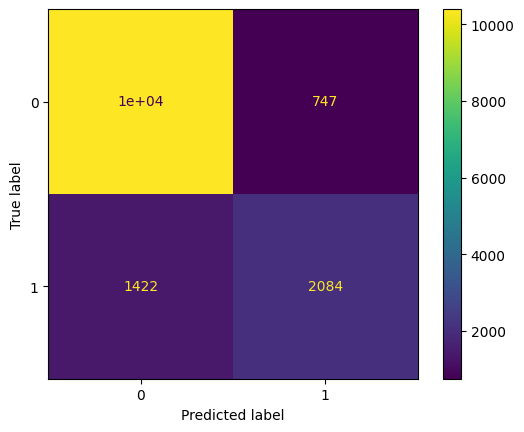

In [6]:
conf_matrix = confusion_matrix(y_test, preds)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

## Find all valid if-thens with all respective coverages and correctness, for all subgroups.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [7]:
for col in cate_features:
    X_test[col] = X_test[col].astype('object')

In [8]:
#ifthens_coverage_correctness = valid_ifthens_with_coverage_correctness(
#     X_test,
#     model=model,
#     sensitive_attribute='sex',
#     missing_subgroup_val="Unknown"
# )

#print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
#rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

In [9]:
 #### Uncomment if you wish to save rules object on disk

#import dill

#with open("rulesAdultFairTest.data", "wb") as outf:
#     dill.dump(rules_by_if, outf)

In [10]:

import dill

with open("rulesAdultFairTest.data", "rb") as inf:
    rules_by_if = dill.load(inf)


In [11]:
K = 10

# keep K ifs with maximum coverage on Females
# TODO: the below is currently dataset dependent
# rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: e[1]["F"][0][1], reverse=True)[:K]

# keep K ifs with maximum absolute difference in correctness between Males and Females.
# TODO: the below is currently dataset dependent
rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: abs(e[1][" Male"][1][0][1]-e[1][" Female"][1][0][1]), reverse=True)[:K]

rules_by_if_filtered = dict(rules_by_if_filtered)

print(recourse_report_reverse(rules_by_if_filtered))

If capital-gain = 0, race =  White, education-num = 9, occupation =  Exec-managerial, capital-loss = 0, native-country =  United-States:
	Subgroup ' Female', 2.1749% covered
		Make capital-gain = 0, race =  White, education-num = 14, occupation =  Exec-managerial, capital-loss = 0, native-country =  United-States with correctness 9.1837%.
	Subgroup ' Male', 1.7513% covered
		Make capital-gain = 0, race =  White, education-num = 14, occupation =  Exec-managerial, capital-loss = 0, native-country =  United-States with correctness 76.5625%.
If capital-gain = 0, race =  White, education-num = 9, occupation =  Exec-managerial, native-country =  United-States:
	Subgroup ' Female', 2.2415% covered
		Make capital-gain = 0, race =  White, education-num = 14, occupation =  Exec-managerial, native-country =  United-States with correctness 9.9010%.
	Subgroup ' Male', 1.7513% covered
		Make capital-gain = 0, race =  White, education-num = 14, occupation =  Exec-managerial, native-country =  United-

# Filter rules by different scoring functions

Here, we explore more sophisticated ways of picking the "top" K rules and showing only those.

We start ranking the rule "groups" (all recourses for a single "if") by averaging out the costs of all suggested recourses, weighted by the respective correctness. For now, the "cost" of a recourse is simply the number of features whose value changes (and the magnitude of the change for numerical features, but here there are none).

In [12]:
feature_weights = {"sex": 1, "age": 1}
comparators = gfacts.naive_feature_change_builder(num_cols=num_features, cate_cols=cate_features, feature_weights=feature_weights)
params = ParameterProxy(featureChanges=comparators)

## For each if-group, inner product of then costs and correctness-es, divided by the number of terms

In [13]:
rules_max_costdiff_sorted = gfacts.sort_triples_by_max_costdiff(rules_by_if, params=params)

top = dict(rules_max_costdiff_sorted[:K])
print(recourse_report_reverse(
    top,
    population_sizes = {" Male": (X.sex == " Male").sum(), " Female": (X.sex == " Female").sum()},
    missing_subgroup_val="Unknown",
    subgroup_costs=gfacts.calculate_all_if_subgroup_costs(list(top.keys()), list(top.values()))
))

If native-country =  United-States, occupation =  Exec-managerial, capital-gain = 0, capital-loss = 0:
	Subgroup ' Female', 8.3666% covered out of 16192
		Make native-country =  United-States, occupation =  Prof-specialty, capital-gain = 7688, capital-loss = 0 with correctness 27.8515%.
		Aggregate cost of the above recourses = 0.557029
	Subgroup ' Male', 5.6916% covered out of 32650
		Make native-country =  United-States, occupation =  Prof-specialty, capital-gain = 7688, capital-loss = 0 with correctness 77.4038%.
		Aggregate cost of the above recourses = 1.54808
If native-country =  United-States, occupation =  Exec-managerial, capital-gain = 0, race =  White:
	Subgroup ' Female', 7.3458% covered out of 16192
		Make native-country =  United-States, occupation =  Prof-specialty, capital-gain = 7688, race =  White with correctness 31.1178%.
		Aggregate cost of the above recourses = 0.622356
	Subgroup ' Male', 5.3769% covered out of 32650
		Make native-country =  United-States, occupat

#### Filter rules that are approximately contained in other rules.

First, we filter only the top rules.

In [14]:
print(recourse_report_reverse(
    gfacts.filter_contained_rules(top),
    population_sizes = {" Male": (X.sex == " Male").sum(), " Female": (X.sex == " Female").sum()},
    missing_subgroup_val="Unknown",
    subgroup_costs=gfacts.calculate_all_if_subgroup_costs(list(top.keys()), list(top.values()))
))

If native-country =  United-States, occupation =  ?, capital-loss = 0, capital-gain = 0:
	Subgroup ' Female', 6.9685% covered out of 16192
		Make native-country =  United-States, occupation =  Exec-managerial, capital-loss = 0, capital-gain = 15024 with correctness 64.3312%.
		Make native-country =  United-States, occupation =  Prof-specialty, capital-loss = 0, capital-gain = 15024 with correctness 60.5096%.
		Aggregate cost of the above recourses = 1.24841
	Subgroup ' Male', 4.9528% covered out of 32650
		Make native-country =  United-States, occupation =  Exec-managerial, capital-loss = 0, capital-gain = 15024 with correctness 87.5691%.
		Make native-country =  United-States, occupation =  Prof-specialty, capital-loss = 0, capital-gain = 15024 with correctness 84.5304%.
		Aggregate cost of the above recourses = 1.72099
If native-country =  United-States, occupation =  Handlers-cleaners, capital-gain = 0:
	Subgroup ' Female', 1.3981% covered out of 16192
		Make native-country =  Unite

Now, we filter all rules, and then pick the top.

In [15]:
rules_max_costdiff_sorted_filtered = gfacts.filter_contained_rules(dict(gfacts.sort_triples_by_max_costdiff(rules_by_if, params=params)))

top = dict(list(rules_max_costdiff_sorted_filtered.items())[:K])
print(recourse_report_reverse(
    top,
    population_sizes = {" Male": (X.sex == " Male").sum(), " Female": (X.sex == " Female").sum()},
    missing_subgroup_val="Unknown",
    subgroup_costs=gfacts.calculate_all_if_subgroup_costs(list(top.keys()), list(top.values()))
))

If capital-gain = 0:
	Subgroup ' Female', 96.2716% covered out of 16192
		Make capital-gain = 15024 with correctness 64.5459%.
		Make capital-gain = 7688 with correctness 17.4735%.
		Make capital-gain = 7298 with correctness 15.3066%.
		Make capital-gain = 99999 with correctness 100.0000%.
		Make capital-gain = 5178 with correctness 8.7828%.
		Make capital-gain = 3103 with correctness 4.5874%.
		Aggregate cost of the above recourses = 0.35116
	Subgroup ' Male', 96.5522% covered out of 32650
		Make capital-gain = 15024 with correctness 84.5543%.
		Make capital-gain = 7688 with correctness 54.3574%.
		Make capital-gain = 7298 with correctness 52.2460%.
		Make capital-gain = 99999 with correctness 100.0000%.
		Make capital-gain = 5178 with correctness 39.1384%.
		Make capital-gain = 3103 with correctness 23.0693%.
		Aggregate cost of the above recourses = 0.588942
If Workclass =  Private, capital-gain = 0:
	Subgroup ' Female', 69.8402% covered out of 16192
		Make Workclass =  Local-gov, c

## For each if-group, minimum cost of change among thens that surpass a correctness threshold

In [16]:
rules_max_costdiff_sorted = gfacts.sort_triples_by_max_costdiff_ignore_nans(
    rules_by_if,
    params=params,
    group_calculator=gfacts.if_group_cost_min_change_correctness_threshold,
    cor_thres=0.5
)

pop_sizes = {sg: (X["sex"] == sg).sum() for sg in X["sex"].unique()}
top = dict(rules_max_costdiff_sorted[:K])
print(recourse_report_reverse(
    top,
    population_sizes = pop_sizes,
    subgroup_costs=gfacts.calculate_all_if_subgroup_costs(
        list(top.keys()),
        list(top.values()),
        group_calculator=gfacts.if_group_cost_min_change_correctness_threshold,
        cor_thres=0.5
    )
))

If capital-gain = 0, capital-loss = 0:
	Subgroup ' Female', 93.4976% covered out of 16192
		Make capital-gain = 7688, capital-loss = 0 with correctness 16.6627%.
		Make capital-gain = 7298, capital-loss = 0 with correctness 14.5502%.
		Make capital-gain = 0, capital-loss = 1977 with correctness 6.1476%.
		Make capital-gain = 0, capital-loss = 1902 with correctness 5.7916%.
		Make capital-gain = 0, capital-loss = 1887 with correctness 5.7916%.
		Make capital-gain = 3103, capital-loss = 0 with correctness 4.3437%.
		Aggregate cost of the above recourses = inf
	Subgroup ' Male', 93.9116% covered out of 32650
		Make capital-gain = 7688, capital-loss = 0 with correctness 53.8316%.
		Make capital-gain = 7298, capital-loss = 0 with correctness 51.7337%.
		Make capital-gain = 0, capital-loss = 1977 with correctness 30.1428%.
		Make capital-gain = 0, capital-loss = 1902 with correctness 29.0064%.
		Make capital-gain = 0, capital-loss = 1887 with correctness 28.6713%.
		Make capital-gain = 3103,

Now the pruned rules.

In [17]:
print(recourse_report_reverse(
    gfacts.filter_contained_rules(top),
    population_sizes = {" Male": (X.sex == " Male").sum(), " Female": (X.sex == " Female").sum()},
    missing_subgroup_val="Unknown",
    subgroup_costs=gfacts.calculate_all_if_subgroup_costs(list(top.keys()), list(top.values()),
    group_calculator=gfacts.if_group_cost_min_change_correctness_threshold,
    cor_thres=0.5)
))

If capital-gain = 0, capital-loss = 0:
	Subgroup ' Female', 93.4976% covered out of 16192
		Make capital-gain = 7688, capital-loss = 0 with correctness 16.6627%.
		Make capital-gain = 7298, capital-loss = 0 with correctness 14.5502%.
		Make capital-gain = 0, capital-loss = 1977 with correctness 6.1476%.
		Make capital-gain = 0, capital-loss = 1902 with correctness 5.7916%.
		Make capital-gain = 0, capital-loss = 1887 with correctness 5.7916%.
		Make capital-gain = 3103, capital-loss = 0 with correctness 4.3437%.
		Aggregate cost of the above recourses = inf
	Subgroup ' Male', 93.9116% covered out of 32650
		Make capital-gain = 7688, capital-loss = 0 with correctness 53.8316%.
		Make capital-gain = 7298, capital-loss = 0 with correctness 51.7337%.
		Make capital-gain = 0, capital-loss = 1977 with correctness 30.1428%.
		Make capital-gain = 0, capital-loss = 1902 with correctness 29.0064%.
		Make capital-gain = 0, capital-loss = 1887 with correctness 28.6713%.
		Make capital-gain = 3103,

## For each if-group, minimum cost of change among thens that surpass a correctness threshold

Before, when, for a subgroup, there were no thens that surpassed the threshold, the minimum cost of change was valued as infinity, and thus, as it is evident in the results, the algorithm finds many rules for which some groups surpass the threshold and some groups do not (because for those rules the difference between maximum and minimum cost of the subgroups evaluates to infinity).

Here, the difference is that we will ignore altogether rules for which the correctness drops below the threshold for all recourses (for some subgroup), considering them as "empty".

In [18]:
rules_max_costdiff_sorted = gfacts.sort_triples_by_max_costdiff_ignore_nans_infs(
    rules_by_if,
    params=params,
    group_calculator=gfacts.if_group_cost_min_change_correctness_threshold,
    cor_thres=0.5
)

pop_sizes = {sg: (X["sex"] == sg).sum() for sg in X["sex"].unique()}
top = dict(rules_max_costdiff_sorted[:K])
print(recourse_report_reverse(
    gfacts.filter_by_correctness(top, threshold=0.5),
    population_sizes = pop_sizes,
    subgroup_costs=gfacts.calculate_all_if_subgroup_costs(
        list(top.keys()),
        list(top.values()),
        group_calculator=gfacts.if_group_cost_min_change_correctness_threshold,
        cor_thres=0.5
    )
))

If capital-gain = 0, race =  White:
	Subgroup ' Female', 76.5868% covered out of 16192
		Make capital-gain = 99999, race =  White with correctness 100.0000%.
		Aggregate cost of the above recourses = 1.0
	Subgroup ' Male', 83.6913% covered out of 32650
		Make capital-gain = 7688, race =  White with correctness 56.6781%.
		Make capital-gain = 7298, race =  White with correctness 54.5856%.
		Make capital-gain = 99999, race =  White with correctness 100.0000%.
		Aggregate cost of the above recourses = 1.0
If native-country =  United-States, capital-gain = 0, race =  White:
	Subgroup ' Female', 70.7501% covered out of 16192
		Make native-country =  United-States, capital-gain = 99999, race =  White with correctness 100.0000%.
		Aggregate cost of the above recourses = 1.0
	Subgroup ' Male', 76.5768% covered out of 32650
		Make native-country =  United-States, capital-gain = 7688, race =  White with correctness 58.4242%.
		Make native-country =  United-States, capital-gain = 7298, race =  Wh

Now the pruned rules.

In [19]:
print(recourse_report_reverse(
    gfacts.filter_by_correctness(gfacts.filter_contained_rules(top), threshold=0.5),
    population_sizes = {" Male": (X.sex == " Male").sum(), " Female": (X.sex == " Female").sum()},
    missing_subgroup_val="Unknown",
    subgroup_costs=gfacts.calculate_all_if_subgroup_costs(list(top.keys()), list(top.values()),
    group_calculator=gfacts.if_group_cost_min_change_correctness_threshold,
    cor_thres=0.5)
))

If capital-gain = 0, race =  White:
	Subgroup ' Female', 76.5868% covered out of 16192
		Make capital-gain = 99999, race =  White with correctness 100.0000%.
		Aggregate cost of the above recourses = 1.0
	Subgroup ' Male', 83.6913% covered out of 32650
		Make capital-gain = 7688, race =  White with correctness 56.6781%.
		Make capital-gain = 7298, race =  White with correctness 54.5856%.
		Make capital-gain = 99999, race =  White with correctness 100.0000%.
		Aggregate cost of the above recourses = 1.0
If Workclass =  Private, capital-gain = 0, race =  White:
	Subgroup ' Female', 56.3693% covered out of 16192
		Make Workclass =  Private, capital-gain = 99999, race =  White with correctness 100.0000%.
		Aggregate cost of the above recourses = 1.0
	Subgroup ' Male', 59.6388% covered out of 32650
		Make Workclass =  Private, capital-gain = 7298, race =  White with correctness 52.3973%.
		Make Workclass =  Private, capital-gain = 7688, race =  White with correctness 54.4850%.
		Make Workcl